In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.callbacks import LearningRateScheduler
import math
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
import rasterio
from torch.utils.data import TensorDataset, DataLoader
import seaborn as sns
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

In [3]:
def inverse_scaling(scaled_data, original_min, original_max):
    return scaled_data * (original_max - original_min) + original_min

In [4]:
def plot_diag(x,y,name):
    plt.figure(figsize=(14,7))
    plt.bar(x, y)
    plt.xlabel('Date')
    plt.ylabel(f'{name}')
    plt.title(f'{name} over Time')
    plt.show()

In [5]:
def plot_loss(train_losses):
    plt.figure(figsize=(10,5))
    plt.plot(train_losses, label='Training Loss')
#     plt.plot(val_losses, label='Validation Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss over time")
    plt.legend()
    plt.show()

In [6]:
def standardise_data(data, dtype='train', scaler=None):
    if dtype == 'train':
        # Create a scaler object
        scaler = StandardScaler()
        # Fit and transform the training data
        data = np.array(data)
        data_norm = scaler.fit_transform(data)
    elif dtype == 'test':
        # Only transform the test set
        data_norm = scaler.transform(data)
    
    return data_norm, scaler

In [7]:
def minmax_data(data, dtype='train', scaler=None):
    if dtype == 'train':
        # Create a scaler object
        scaler = MinMaxScaler()
        # Fit and transform the data
        data = np.array(data)
        data_norm = scaler.fit_transform(data)
    elif dtype == 'test':
        data_norm = scaler.transform(data)
    
    return data_norm, scaler

In [8]:
def rebuild_data(df, var, start_month=10, start_day=1):
    input_values = []
    target_values = []

    for location in df['loc'].unique():
        loc_df = df[df['loc'] == location]  # select the current location only
        loc_df['date'] = pd.to_datetime(loc_df['date'])
        loc_df = loc_df.sort_values('date')  # sort the data
        loc_df.reset_index(drop=True, inplace=True)  # reset the index

        snow_season_start = None
        for i in range(len(loc_df)-1):
            # Check if it's the start of a snow season
            if loc_df['date'].dt.month[i] == start_month and loc_df['date'].dt.day[i] == start_day:
                snow_season_start = i

            # make sure the samples are continuous
            if snow_season_start is not None and i == 0:
                input_values.append(loc_df[var][snow_season_start:1])
                target_values.append(loc_df['station_SWE'][1])
            elif snow_season_start is not None and (loc_df['date'][i] - loc_df['date'][i-1]).days == 1:
                input_values.append(loc_df[var][snow_season_start:i+1])
                target_values.append(loc_df['station_SWE'][i+1])

    input_values = np.array(input_values, dtype=object)
    target_values = np.array(target_values)

    return input_values, target_values

In [9]:
def split_dataset(X, Y, test_size=0.2,random_state=42):
    # Split into train and test sets
    X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=test_size, random_state=random_state)
    
    return X_train, X_val, y_train, y_val

In [10]:
def get_data_loaders(input_train, target_train, input_test, target_test, batch_size=32):
    # compute lengths for each sequence
    lengths_train = [len(seq) for seq in input_train]
#     lengths_val = [len(seq) for seq in input_val]
    lengths_test = [len(seq) for seq in input_test]

    X_train = [torch.tensor(seq.values).float() for seq in input_train]
#     X_val = [torch.tensor(seq.values).float() for seq in input_val]
    X_test = [torch.tensor(seq.values).float() for seq in input_test]

    y_train = torch.from_numpy(target_train).float()
#     y_val = torch.from_numpy(target_val).float()
    y_test = torch.from_numpy(target_test).float()

    X_train = pad_sequence(X_train, batch_first=True, padding_value=0)
#     X_val = pad_sequence(X_val, batch_first=True, padding_value=0)
    X_test = pad_sequence(X_test, batch_first=True, padding_value=0)

    train_data = TensorDataset(X_train, y_train, torch.LongTensor(lengths_train))
    train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size)
    
#     val_data = TensorDataset(X_val, y_val, torch.LongTensor(lengths_val))
#     val_loader = DataLoader(val_data, shuffle=False, batch_size=batch_size)

    test_data = TensorDataset(X_test, y_test, torch.LongTensor(lengths_test))
    test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

    return train_loader, test_loader


In [11]:
def kge(real, pred):
    # reshape the input into one dim
    r = np.corrcoef(pred, real)[0,1]
    alpha = np.std(pred) / np.std(real)
    beta = np.mean(pred) / np.mean(real)
    kge = 1 - np.sqrt((r-1)**2 + (alpha-1)**2 + (beta-1)**2)
    return kge

In [12]:
def evaluate_model(test_loader, model, y_scaler):
    # evaluation mode
    model.eval()

    test_predictions = []
    y_test_real = []

    # predict on the test data
    with torch.no_grad():
        for i, (X, Y, lengths) in enumerate(test_loader):
            X = X.float()
            Y = Y.float()
            outputs = model(X, lengths) 
            test_predictions.append(outputs.numpy())
            y_test_real.append(Y.numpy())

    # concatenate the list of numpy arrays into one numpy array
    test_predictions = np.concatenate(test_predictions).reshape(-1, 1)
    y_test_real = np.concatenate(y_test_real).reshape(-1, 1)

    # reverse the scaling
    test_pred = y_scaler.inverse_transform(test_predictions)
    y_test_ori = y_scaler.inverse_transform(y_test_real)
    
    # Calculate the mean squared error
    mse_test = mean_squared_error(y_test_ori, test_pred)
    kge_test = kge(y_test_ori.reshape(-1), test_pred.reshape(-1))

    print('Mean Squared Error on Test Data:', mse_test)
    print('Kling-Gupta efficiency on Test Data:', kge_test)
    
    plt.figure(figsize=(8, 8))
    plt.scatter(y_test_ori, test_pred, alpha=0.5)
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title('Scatter Plot of True vs Predicted Values')
    plt.plot([min(y_test_ori), max(y_test_ori)], [min(y_test_ori), max(y_test_ori)], color='red')  # plot y_true=y_pred
    plt.show()


# Read data

In [29]:
folder_path = '/Users/yz6622/Desktop/IRP/dataset/swiss_station/Preprocessed_data/'

In [30]:
file_path = folder_path + 'train.csv'

# read data
df = pd.read_csv(file_path)

In [31]:
# set the datetime and sort the values
df = df.sort_values(by="date")
df.reset_index(drop=True, inplace=True)

In [32]:
file_path = folder_path + 'test.csv'

# read data
df_test = pd.read_csv(file_path)

# Data pre-process

In [33]:
# inverse all the features
df['HS'] = inverse_scaling(df['HS'], 0.0, 555.7083333333334)
df['precipitation'] = inverse_scaling(df['precipitation'], 0, 0.0508635304868221)
df['snowfall'] = inverse_scaling(df['snowfall'], 0, 0.0508402287960052)
df['solar_radiation'] = inverse_scaling(df['solar_radiation'], 0, 22261948.0)
df['temperature'] = inverse_scaling(df['temperature'], -29.88636779785156, 39.6531982421875)
df['rain'] = inverse_scaling(df['rain'], 0, 0.0488765742629765)
df['month'] = inverse_scaling(df['month'], 1, 12)

In [34]:
# inverse all the features
df_test['HS'] = inverse_scaling(df_test['HS'], 0.0, 555.7083333333334)
df_test['precipitation'] = inverse_scaling(df_test['precipitation'], 0, 0.0508635304868221)
df_test['snowfall'] = inverse_scaling(df_test['snowfall'], 0, 0.0508402287960052)
df_test['solar_radiation'] = inverse_scaling(df_test['solar_radiation'], 0, 22261948.0)
df_test['temperature'] = inverse_scaling(df_test['temperature'], -29.88636779785156, 39.6531982421875)
df_test['rain'] = inverse_scaling(df_test['rain'], 0, 0.0488765742629765)
df_test['month'] = inverse_scaling(df_test['month'], 1, 12)

In [35]:
# Standardize specific columns
df['temperature'], scaler_temp = standardise_data(np.array(df['temperature']).reshape(-1,1), 'train')
df[['HS','precipitation','snowfall','solar_radiation','rain','month']], scaler_minmax = minmax_data(df[['HS','precipitation','snowfall','solar_radiation','rain','month']], 'train')
df['station_SWE'], scaler_y = minmax_data(np.array(df['station_SWE']).reshape(-1,1), 'train')

# Apply the same scaling to test set
df_test['temperature'], _ = standardise_data(np.array(df_test['temperature']).reshape(-1,1), 'test', scaler_temp)
df_test[['HS','precipitation','snowfall','solar_radiation','rain','month']], _ = minmax_data(df_test[['HS','precipitation','snowfall','solar_radiation','rain','month']], 'test', scaler_minmax)
df_test['station_SWE'], _ = minmax_data(np.array(df_test['station_SWE']).reshape(-1,1), 'test', scaler_y)

# Model

In [36]:
class LSTM(nn.Module):
    def __init__(self, input_dim=1, hidden_dims=50, num_layers=1, num_epochs=60, output_dims=1):
        super(LSTM, self).__init__()
        
        self.lstm1 = nn.LSTM(input_dim, hidden_dims, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dims, output_dims)
        self.num_epochs = num_epochs

    def forward(self, x, lengths):
        # pack the sequences
        x_packed = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        
        # pass the packed sequence through LSTM
        lstm_out, (h_n, c_n) = self.lstm1(x_packed)
        
        # unpack
        lstm_out, _ = pad_packed_sequence(lstm_out, batch_first=True)
        
        # use the final hidden state as output
        out = self.fc(h_n[-1])
        return out

    def train_model(self, train_loader, optimizer, criterion, scheduler):
        train_losses = []
        val_losses = []
        for epoch in range(self.num_epochs):
            # Training
            self.train()  # Set the model to training mode
            running_train_loss = 0.0
            for i, (X, Y, lengths) in enumerate(train_loader): 
                X = X.float()
                Y = Y.float()
                optimizer.zero_grad()
                outputs = self(X, lengths)  # Pass to the forward method
                loss = criterion(outputs, Y)
                loss.backward()
                optimizer.step()
                running_train_loss += loss.item() * X.size(0)
            avg_train_loss = running_train_loss / len(train_loader.dataset)
            train_losses.append(avg_train_loss)

#             # Validation
#             self.eval()  # Set the model to evaluation mode
#             running_val_loss = 0.0
#             with torch.no_grad():
#                 for i, (X, Y, lengths) in enumerate(val_loader):  
#                     X = X.float()
#                     Y = Y.float()
#                     outputs = self(X, lengths)  
#                     loss = criterion(outputs, Y)
#                     running_val_loss += loss.item() * X.size(0)
#             avg_val_loss = running_val_loss / len(val_loader.dataset)
#             val_losses.append(avg_val_loss)

            print(f'Epoch {epoch+1}/{self.num_epochs}, Train Loss: {avg_train_loss}') # , Val Loss: {avg_val_loss}

            # Decay Learning Rate
            scheduler.step()

        return train_losses#, val_losses


In [37]:
# data preprocess
input_values, target_values = rebuild_data(df_train, ['HS'])
X_test_90, y_test_90 = rebuild_data(df_train_test, ['HS'])
# X_train_90, X_val_90, y_train_90, y_val_90 = split_dataset(input_values, target_values)

In [38]:
# dataloader
train_loader, test_loader = get_data_loaders(input_values, target_values, X_test_90, y_test_90, batch_size=32)

In [39]:
# build model

model = LSTM(input_dim=1, hidden_dims=50, num_epochs=80)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

# train
train_losses = model.train_model(train_loader, optimizer, criterion, scheduler)

Epoch 1/80, Train Loss: 0.1686541124419293
Epoch 2/80, Train Loss: 0.05929792762482988
Epoch 3/80, Train Loss: 0.03042078205853912
Epoch 4/80, Train Loss: 0.01967627277585064
Epoch 5/80, Train Loss: 0.01915237648299193
Epoch 6/80, Train Loss: 0.019193414133336067
Epoch 7/80, Train Loss: 0.019146093707616208
Epoch 8/80, Train Loss: 0.01910399468259309
Epoch 9/80, Train Loss: 0.01906805312377444
Epoch 10/80, Train Loss: 0.01901969671166637
Epoch 11/80, Train Loss: 0.016537251767178445
Epoch 12/80, Train Loss: 0.015789558171195754
Epoch 13/80, Train Loss: 0.015612999506053242
Epoch 14/80, Train Loss: 0.016123218760568925
Epoch 15/80, Train Loss: 0.01595295699956896
Epoch 16/80, Train Loss: 0.015523587886246316
Epoch 17/80, Train Loss: 0.015438821769361169
Epoch 18/80, Train Loss: 0.014869529542287482
Epoch 19/80, Train Loss: 0.015072988757587452
Epoch 20/80, Train Loss: 0.014130927940477695
Epoch 21/80, Train Loss: 0.011864744228855506
Epoch 22/80, Train Loss: 0.01109630286669028
Epoch 23

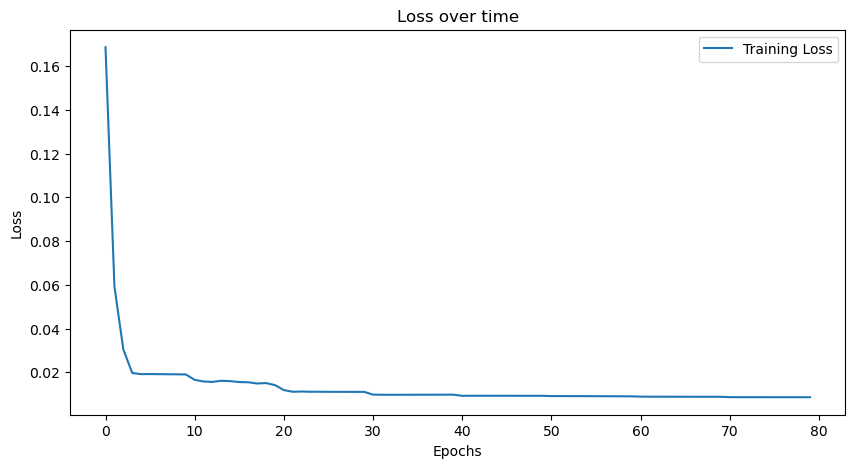

In [40]:
# plot the loss function
plot_loss(train_losses)

Mean Squared Error on Test Data: 64.03187
Kling-Gupta efficiency on Test Data: 0.9474882062805925


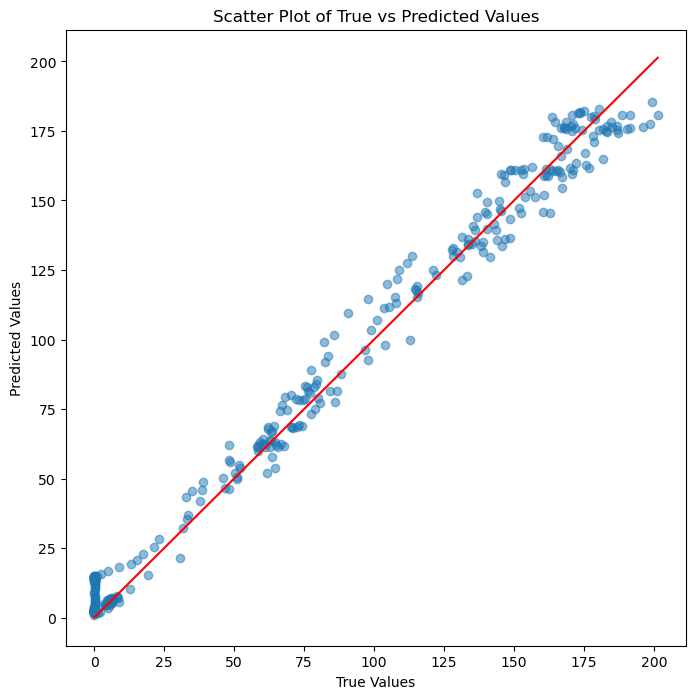

In [41]:
# evaluate
evaluate_model(test_loader, model, scaler_y)

canada - epoch50

Mean Squared Error on Test Data: 307.90793
Kling-Gupta efficiency on Test Data: 0.8881537650265832


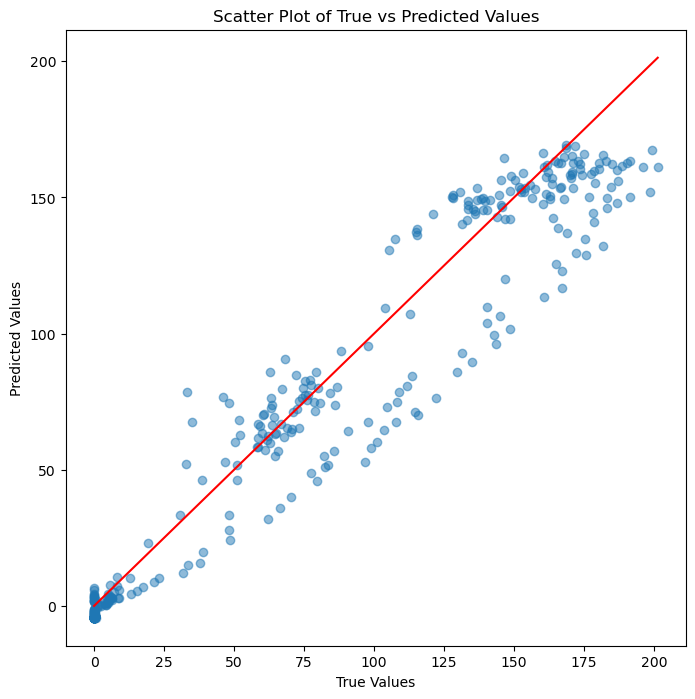

In [28]:
# evaluate
evaluate_model(test_loader, model, scaler_y)